In [5]:
!pip install torchview

In [6]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from deeplearning_model import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from deeplearning_model import evaluate_classification_model as evaluate_model

import torch
import torch.nn as nn
from torchvision import models
from torchview import draw_graph

In [7]:
!pip list|grep kaggle

kaggle                                1.7.4.5
kagglehub                             0.3.12


In [8]:
import json
#username和key改为自己的kaggle的，如果不行，就可以直接用这个
token = {"username":"cskaoyan","key":"b9aafd6b35a0953f67bfe6a18d32117a"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)#json.dump类似于write,比write方便在于可以直接把字典类型数据，变为字符串写入文件

In [9]:
!cat /content/kaggle.json

{"username": "cskaoyan", "key": "b9aafd6b35a0953f67bfe6a18d32117a"}

In [10]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [11]:
!kaggle datasets download -d slothkong/10-monkey-species

Dataset URL: https://www.kaggle.com/datasets/slothkong/10-monkey-species
License(s): CC0-1.0
 97% 528M/547M [00:11<00:00, 24.9MB/s]
100% 547M/547M [00:11<00:00, 51.8MB/s]


In [12]:
!ls -lh datasets/slothkong/10-monkey-species/

total 548M
-rw-r--r-- 1 root root 548M Sep 26  2019 10-monkey-species.zip


In [13]:
!pwd

/content


In [14]:
!unzip -o -d /content /content/datasets/slothkong/10-monkey-species/10-monkey-species.zip

Archive:  /content/datasets/slothkong/10-monkey-species/10-monkey-species.zip
  inflating: /content/monkey_labels.txt  
  inflating: /content/training/training/n0/n0018.jpg  
  inflating: /content/training/training/n0/n0019.jpg  
  inflating: /content/training/training/n0/n0020.jpg  
  inflating: /content/training/training/n0/n0021.jpg  
  inflating: /content/training/training/n0/n0022.jpg  
  inflating: /content/training/training/n0/n0023.jpg  
  inflating: /content/training/training/n0/n0024.jpg  
  inflating: /content/training/training/n0/n0025.jpg  
  inflating: /content/training/training/n0/n0026.jpg  
  inflating: /content/training/training/n0/n0027.jpg  
  inflating: /content/training/training/n0/n0028.jpg  
  inflating: /content/training/training/n0/n0029.jpg  
  inflating: /content/training/training/n0/n0030.jpg  
  inflating: /content/training/training/n0/n0031.jpg  
  inflating: /content/training/training/n0/n0032.jpg  
  inflating: /content/training/training/n0/n0033.jpg  


In [15]:
!ls training/training/

n0  n1	n2  n3	n4  n5	n6  n7	n8  n9


In [16]:
from torchvision.models import resnet50

# 导入并初始化resnet50模型
# 初始化ResNet50模型
model = resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)

# 打印模型结构
print("ResNet50模型结构:")
print(model)

# 计算模型参数数量
total_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数数量: {total_params}")

# 尝试绘制模型结构图，如果没有torchview则给出提示
try:
    # 这里使用torchview的draw_graph进行可视化
    # 输入形状为(1, 3, 224, 224)，即batch_size=1，3通道，224x224图像
    model_graph = draw_graph(
        resnet50,
        input_size=(1, 3, 224, 224),
        expand_nested=True,
        save_graph=False,
        graph_name="ResNet50"
    )
    model_graph.visual_graph  # 在notebook中显示结构图
except Exception as e:
    print("无法绘制模型结构图,请pip install torchviz。")
    print("错误信息:", e)

# 中文注释：
# 1. 导入torchvision的resnet50模型，并加载预训练权重
# 2. 修改最后一层全连接层，使其输出类别数为10
# 3. 打印模型结构
# 4. 使用torchview绘制模型结构图，便于可视化网络结构


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


ResNet50模型结构:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

#加载数据并处理为tensor,自定义数据集类，继承ImageFolder

In [17]:
from pathlib import Path

DATA_DIR = Path("./")

# 自定义数据集类，继承ImageFolder
class MonkeyDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root=root, transform=transform)


# 定义数据预处理
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((224, 224)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2085, 0.2032, 0.1988]))
        #transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2129, 0.2075, 0.2037])  # 标准化，使用ImageNet的均值和标准差
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        #transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2129, 0.2075, 0.2037])  # 标准化，使用ImageNet的均值和标准差
    ]),
}

# 使用自定义的MonkeyDataset加载数据
train_dataset = MonkeyDataset(
    root=DATA_DIR / 'training/training',
    transform=data_transforms['training']
)

test_dataset = MonkeyDataset(
    root=DATA_DIR / 'validation/validation',
    transform=data_transforms['validation']
)

# 打印类别信息
class_names = train_dataset.classes
print(f"类别数量: {len(class_names)}")
print(f"类别名称: {class_names}")

# 查看一个样本
img, label = train_dataset[0]
print(f"图像形状: {img.shape}")  # 应该是[3, 224, 224]
print(f"标签: {label} (类别: {class_names[label]})")


类别数量: 10
类别名称: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
图像形状: torch.Size([3, 224, 224])
标签: 0 (类别: n0)


# 计算train_dataset的均值和方差，做数据归一化

In [18]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2)) #dim=(1, 2)表示在通道维度上求平均
        std += img.std(dim=(1, 2))  #dim=(1, 2)表示在通道维度上求标准差
    mean /= len(ds)
    std /= len(ds)
    return mean, std
cal_mean_std(train_dataset)

(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2129, 0.2075, 0.2037]))

# 创建数据加载器

In [19]:
# 创建数据加载器，
batch_size = 32
train_loader = torch.utils.data.DataLoader( # 转换为张量
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")


训练集大小: 1097
测试集大小: 272
批次大小: 32
训练批次数: 35


# 打印两层模型名字

In [20]:
count = 0
for name, param in model.named_parameters():
    print(name)
    count += 1
    if count >= 2:
        break

conv1.weight
bn1.weight


In [21]:
# resnet50.named_children() 返回一个迭代器，迭代器中的每个元素是一个元组，元组中第一个元素是子模块的名称，第二个元素是子模块

for name, child in model.named_children():
    print(name, child) # 打印子模块的名称和子模块
    break

conv1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


# 搭建模型，定义CNN卷积模型

In [22]:
import torch.nn as nn
import torchvision.models as models

class CNN_ResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 加载预训练的ResNet50模型
        self.resnet = models.resnet50(weights='IMAGENET1K_V2')

        # 冻结所有层的参数
        for param in self.resnet.parameters():
            param.requires_grad = False

        for name, param in self.resnet.named_parameters():
            if name == "layer4.2.conv3.weight":#这一层解冻
                param.requires_grad = True

        # 替换最后的全连接层
        # ResNet50的最后一层fc的输入特征是2048
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

    # def unfreeze_layers(self, num_layers=0):
    #     """解冻最后几层进行微调"""
    #     if num_layers > 0:
    #         # 解冻最后的几个层
    #         layers_to_unfreeze = list(self.resnet.children())[-num_layers:]
    #         print(layers_to_unfreeze)
    #         for layer in layers_to_unfreeze:
    #             for param in layer.parameters():
    #                 param.requires_grad = True


    def unfreeze_all(self):
        """解冻所有层"""
        for param in self.resnet.parameters():
            param.requires_grad = True

# 实列化模型

In [23]:
model = CNN_ResNet50()

# 从train_loader获取第一个批次的数据
data_iter = iter(train_loader)
images, labels = next(data_iter)

# 打印图像形状
print(f"图像形状: {images.shape}")
print(f"标签形状: {labels.shape}")

print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)


print(outputs.shape)

图像形状: torch.Size([32, 3, 224, 224])
标签形状: torch.Size([32])
----------------------------------------------------------------------------------------------------
torch.Size([32, 10])


# 统计各层参数量和总参数量

In [24]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量,p.numel()指参数的个数
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) #p.requires_grad 指参数需要求梯度
print(f"需要求梯度的参数总量: {total_params}")
# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细，named_parameters()返回一个包含模型各层名称和参数的迭代器
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

需要求梯度的参数总量: 1069066
模型总参数量: 23528522

各层参数量明细:
resnet.conv1.weight: 9408 参数
resnet.bn1.weight: 64 参数
resnet.bn1.bias: 64 参数
resnet.layer1.0.conv1.weight: 4096 参数
resnet.layer1.0.bn1.weight: 64 参数
resnet.layer1.0.bn1.bias: 64 参数
resnet.layer1.0.conv2.weight: 36864 参数
resnet.layer1.0.bn2.weight: 64 参数
resnet.layer1.0.bn2.bias: 64 参数
resnet.layer1.0.conv3.weight: 16384 参数
resnet.layer1.0.bn3.weight: 256 参数
resnet.layer1.0.bn3.bias: 256 参数
resnet.layer1.0.downsample.0.weight: 16384 参数
resnet.layer1.0.downsample.1.weight: 256 参数
resnet.layer1.0.downsample.1.bias: 256 参数
resnet.layer1.1.conv1.weight: 16384 参数
resnet.layer1.1.bn1.weight: 64 参数
resnet.layer1.1.bn1.bias: 64 参数
resnet.layer1.1.conv2.weight: 36864 参数
resnet.layer1.1.bn2.weight: 64 参数
resnet.layer1.1.bn2.bias: 64 参数
resnet.layer1.1.conv3.weight: 16384 参数
resnet.layer1.1.bn3.weight: 256 参数
resnet.layer1.1.bn3.bias: 256 参数
resnet.layer1.2.conv1.weight: 16384 参数
resnet.layer1.2.bn1.weight: 64 参数
resnet.layer1.2.bn1.bias: 64 参数
resnet

# 设置交叉熵损失函数，SGD优化器

In [25]:
model = CNN_ResNet50()

# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)

# 训练模型
model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, eval_step=50)



使用设备: cuda:0
训练开始，共1750步


  0%|          | 0/1750 [00:00<?, ?it/s]

早停触发!
99.2647
早停: 在700 步


In [27]:
history['val'][-10:-1]

[{'loss': 0.4807315503849703, 'acc': 98.52941176470588, 'step': 250},
 {'loss': 0.39722761336494894, 'acc': 98.52941176470588, 'step': 300},
 {'loss': 0.3556736164233264, 'acc': 98.8970588235294, 'step': 350},
 {'loss': 0.31344542608541603, 'acc': 98.16176470588235, 'step': 400},
 {'loss': 0.2691109794027665, 'acc': 99.26470588235294, 'step': 450},
 {'loss': 0.24844084767734304, 'acc': 97.79411764705883, 'step': 500},
 {'loss': 0.22534567994229934, 'acc': 99.26470588235294, 'step': 550},
 {'loss': 0.2038319566670586, 'acc': 99.26470588235294, 'step': 600},
 {'loss': 0.19943212410982916, 'acc': 99.26470588235294, 'step': 650}]

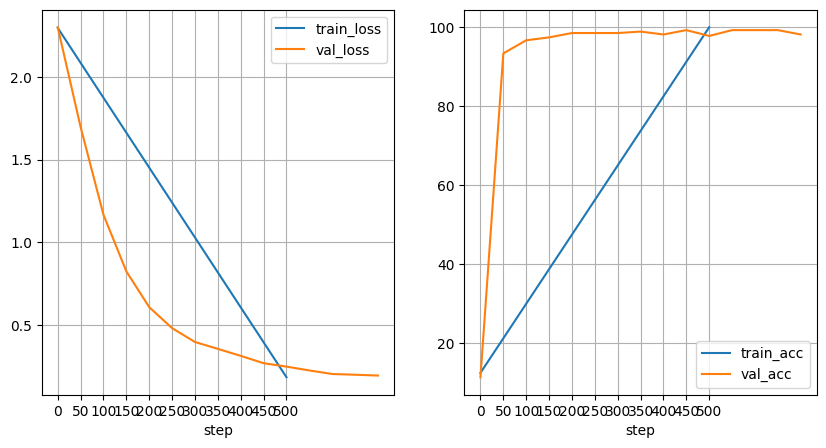

In [28]:
# 绘制学习曲线
plot_learning_curves(history, sample_step=500,eval_step=50)  #横坐标是 steps

In [29]:
# 在测试集上评估模型
test_accuracy = evaluate_model(model, test_loader, device, loss_fn)
test_accuracy

(98.16176470588235, 0.19450224585392895)